In [30]:

import os
import locale
from enum import Enum

import pandas as pd 
import numpy as np 

from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from scipy.optimize import curve_fit

class ModelType(Enum):
    LOGISTIC = 1
    EXPONENTIAL = 2

locale.setlocale(locale.LC_ALL, '')

'LC_CTYPE=en_US.UTF-8;LC_NUMERIC=it_IT.UTF-8;LC_TIME=it_IT.UTF-8;LC_COLLATE=en_US.UTF-8;LC_MONETARY=it_IT.UTF-8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=it_IT.UTF-8;LC_NAME=it_IT.UTF-8;LC_ADDRESS=it_IT.UTF-8;LC_TELEPHONE=it_IT.UTF-8;LC_MEASUREMENT=it_IT.UTF-8;LC_IDENTIFICATION=it_IT.UTF-8'

In [31]:
# Data file to be read:
data_file_path = os.path.join("..","data")
it_data_file_name = "virus-it.csv"
lo_data_file_name = "virus-lombardia.csv"
it_data_file = os.path.join(data_file_path, it_data_file_name)
lo_data_file = os.path.join(data_file_path, lo_data_file_name)

# Place where images are saved:
images_path = os.path.join("..","images")


In [32]:
#
# Load Italian dataset.
#
df = pd.read_csv(it_data_file, sep=',', lineterminator='\n'
                ,low_memory=False)

df["timeStamp"] = pd.to_datetime(df["Data"], format="%d/%m/%Y")
df.sort_values(by=["timeStamp"], inplace=True)

min_date = df['timeStamp'].min()
df['TimeDelta'] = (df['timeStamp'] - min_date).dt.days + 1

(df.shape, df.dtypes)

((16, 7),
 Data                    object
 Casi attuali             int64
 Morti                    int64
 Guariti                  int64
 Totale                   int64
 timeStamp       datetime64[ns]
 TimeDelta                int64
 dtype: object)

In [33]:
#
# Load Lombardy dataset.
#
df_lo = pd.read_csv(lo_data_file, sep=',', lineterminator='\n', low_memory=False)

df_lo["timeStamp"] = pd.to_datetime(df_lo["Data"], format="%d/%m/%Y")
df_lo.sort_values(by=["timeStamp"], inplace=True)

min_date = df_lo['timeStamp'].min()
df_lo['TimeDelta'] = (df_lo['timeStamp'] - min_date).dt.days + 1

(df.shape, df.dtypes)

((16, 7),
 Data                    object
 Casi attuali             int64
 Morti                    int64
 Guariti                  int64
 Totale                   int64
 timeStamp       datetime64[ns]
 TimeDelta                int64
 dtype: object)

In [34]:
df.head(20)

,Data,Casi attuali,Morti,Guariti,Totale,timeStamp,TimeDelta
15,01/03/2020,1577,34,83,1694,2020-03-01,1
14,02/03/2020,1835,52,149,2036,2020-03-02,2
13,03/03/2020,2263,79,160,2502,2020-03-03,3
12,04/03/2020,2706,107,276,3089,2020-03-04,4
11,05/03/2020,3296,148,414,3858,2020-03-05,5
10,06/03/2020,3916,197,523,4636,2020-03-06,6
9,07/03/2020,5061,233,589,5883,2020-03-07,7
8,08/03/2020,6387,366,622,7375,2020-03-08,8
7,09/03/2020,7985,463,724,9172,2020-03-09,9
6,10/03/2020,8514,631,1004,10149,2020-03-10,10


In [35]:
df_lo.head(20)

,Data,Ricoverati con sintomi,Terapia intensiva,Isolamento domiciliare,Totale positivi,Dimessi,Deceduti,Totale,Tamponi,timeStamp,TimeDelta
16,01/03/2020,406,106,375,887,73,24,984,6879,2020-03-01,1
15,02/03/2020,478,127,472,1077,139,38,1254,7925,2020-03-02,2
14,03/03/2020,698,167,461,1326,139,55,1520,9577,2020-03-03,3
13,04/03/2020,877,209,411,1497,250,73,1820,12138,2020-03-04,4
12,05/03/2020,1169,244,364,1777,376,98,2251,12354,2020-03-05,5
11,06/03/2020,1622,309,77,2008,469,135,2612,13556,2020-03-06,6
10,07/03/2020,1661,359,722,2742,524,15,3420,15778,2020-03-07,7
9,08/03/2020,2217,399,756,3372,550,267,4189,18534,2020-03-08,8
8,09/03/2020,2802,440,1248,4490,646,333,5469,20135,2020-03-09,9
7,10/03/2020,3319,466,642,4427,896,468,5791,2149,2020-03-10,10


In [22]:
# ------------------------------------------------------------
# Model fitting
# ------------------------------------------------------------

# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end
    
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

def get_fitted_model_params(df, x_index, y_index, p0_estimate, function):
    """
    
    """
    model_params = None
    try:
        #dates = list(df.iloc[:,5])
        y = list(df.iloc[:,y_index])
        x = list(df.iloc[:,x_index])
        model_params = curve_fit(function, x, y, p0=p0_estimate)
        
    except Exception as ex:
        print("get_fitted_model_params failed - {ex}".format(ex=ex))
    return model_params

x_index = list(df.columns).index('TimeDelta')
y_index = list(df.columns).index('Totale')
it_log_fit = get_fitted_model_params(df, x_index=x_index, y_index=y_index, p0_estimate=[2,50,80000], function=logistic_model)

x_index = list(df_lo.columns).index('TimeDelta')
y_index = list(df_lo.columns).index('Totale')
lom_log_fit = get_fitted_model_params(df_lo, x_index=x_index, y_index=y_index, p0_estimate=[2,50,80000], function=logistic_model)

a = f'{it_log_fit[0][0]:.2f}'
b = f'{it_log_fit[0][1]:.2f}'
c = f'{it_log_fit[0][2]:.2f}'

("a",a,"b",b,"c",c, it_exp_fit)


('a',
 '4.56',
 'b',
 '18.15',
 'c',
 '73258.14',
 (array([4.56085742e+00, 1.81503247e+01, 7.32581395e+04]),
  array([[1.59870099e-02, 9.23164264e-02, 8.65778312e+02],
         [9.23164264e-02, 5.77305686e-01, 5.50717520e+03],
         [8.65778312e+02, 5.50717520e+03, 5.28116819e+07]])))

In [23]:
a = f'{lom_log_fit[0][0]:.2f}'
b = f'{lom_log_fit[0][1]:.2f}'
c = f'{lom_log_fit[0][2]:.2f}'

("a",a,"b",b,"c",c, it_exp_fit)


('a',
 '4.29',
 'b',
 '15.29',
 'c',
 '27170.51',
 (array([4.56085742e+00, 1.81503247e+01, 7.32581395e+04]),
  array([[1.59870099e-02, 9.23164264e-02, 8.65778312e+02],
         [9.23164264e-02, 5.77305686e-01, 5.50717520e+03],
         [8.65778312e+02, 5.50717520e+03, 5.28116819e+07]])))

In [24]:
# ------------------------------------------------------------
# ------------------------------------------------------------
# Some common functions.
# ------------------------------------------------------------
# ------------------------------------------------------------
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom')

def set_axes_common_properties(axe, no_grid=False, border=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(border)
        axe.spines['left'].set_visible(border)
        axe.spines['right'].set_visible(border)
        axe.spines['bottom'].set_visible(border)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

def text_box(ax, text, colors=["#FFFFFF", "#000000"], fontsize=14, x=0, y=0):
    """
    """
    rv = False
    try:
        edgecolor = "none"
        boxstyle = "square"
        if len(colors) >= 3 and colors[2] is not None:
            edgecolor = colors[2]
            boxstyle = "round,pad=1"
        ax.text(x, y
               ,text
               ,ha="left", va="center" 
               ,bbox=dict(boxstyle = boxstyle, facecolor = colors[0], edgecolor = edgecolor)
               ,color=colors[1]
               ,fontsize=fontsize)
        set_axes_common_properties(ax, no_grid=True)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
    except Exception as ex:
        print("text_box failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv   

In [25]:
#
#
#

def c_virus_chart(ax, x, y, colors=["#0000e6", "#727170"],log=False, title=None):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, no_grid=False)
        #ax.set_xlim(time_limits)

        time_limits = [x.min() - pd.Timedelta(hours=10) 
                      ,x.max() + pd.Timedelta(hours=10)]
        ax.set_xlim(time_limits)
        
        if log == True:
            ax.set_yscale('log')
            ax.set_ylabel("Numero - scala logaritmica", fontsize=12)
        else:
            ax.set_ylabel("Numero", fontsize=12)
            if title is not None:
                ax.set_title(title, fontsize=16)
            else:
                ax.set_title("Progressione contagio COVID-19", fontsize=16)
    
        ax.scatter(x, y, color=colors[0], s=7)
        ax.plot(x, y, 'b-', linewidth=1.0, color=colors[1], label="Totale casi")
        
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        ax.legend(fontsize=12, loc='lower right')
            
    except Exception as ex:
        print("c_virus_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


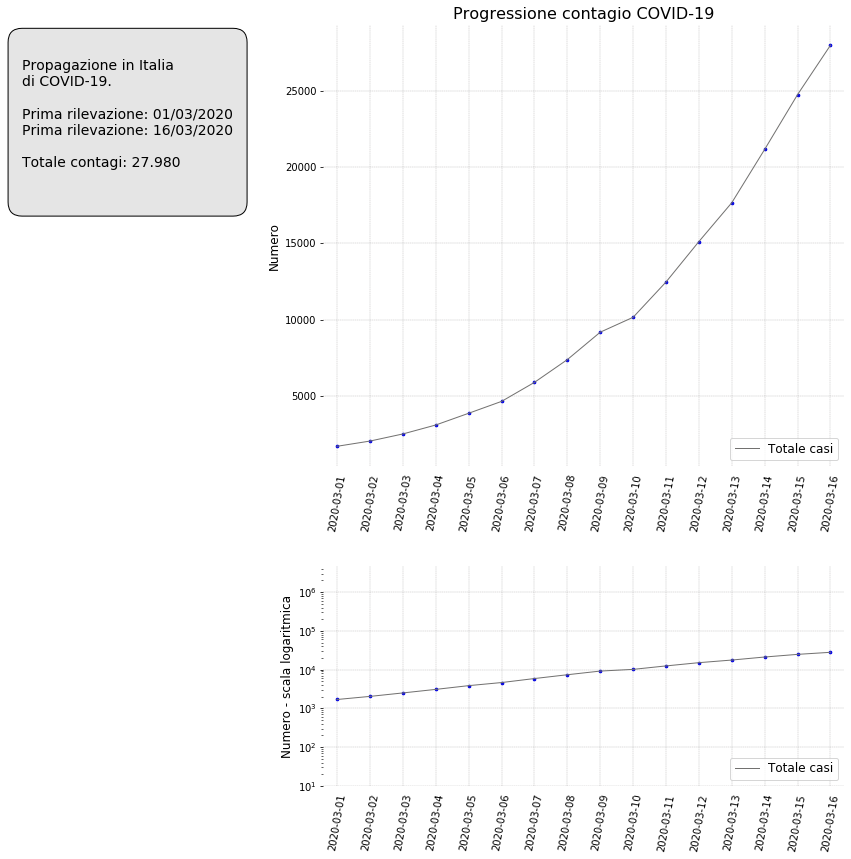

In [26]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df["timeStamp"].min().strftime(date_format)
max_date = df["timeStamp"].max().strftime(date_format)
total = f'{df["Totale"].max():n}'

# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 14))
gs1 = gridspec.GridSpec(2, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.5 
                       ,width_ratios=[2, 7]
                       ,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Italia
di COVID-19.

Prima rilevazione: {d1}
Prima rilevazione: {d2}

Totale contagi: {t}

""".format(d1=min_date, d2=max_date
          ,t=total)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.78)

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
c_virus_chart(ax[idx],x=x, y=df["Totale"])

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
c_virus_chart(ax[idx],x=x, y=df["Totale"],log=True)

plt.savefig(os.path.join(images_path,"covid19_chart.png"))


c_virus_chart failed - x and y must be the same size


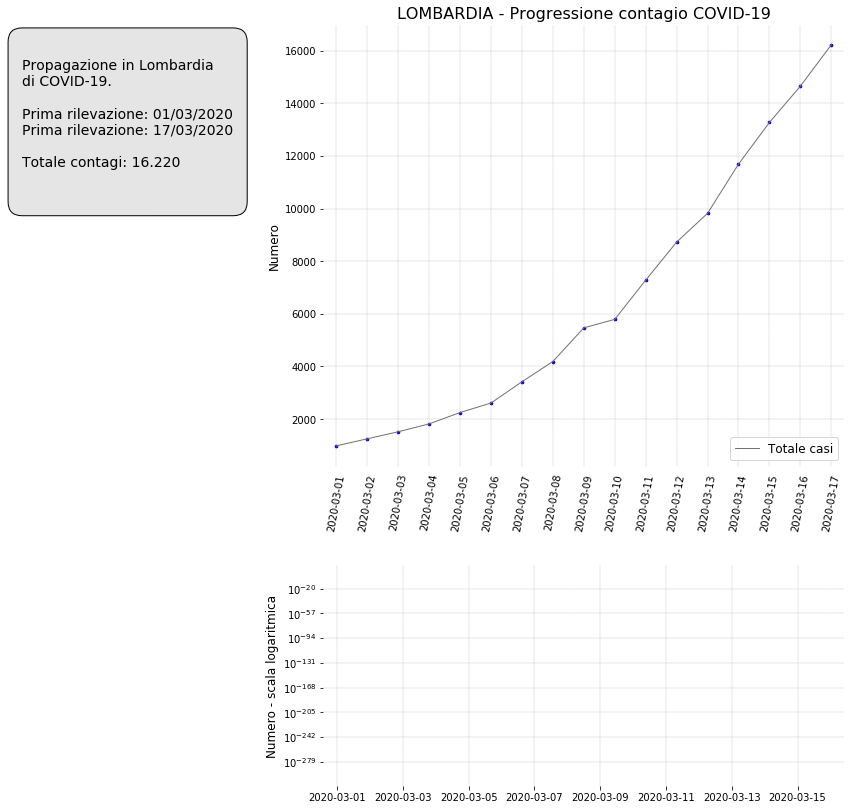

In [27]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df_lo["timeStamp"].min().strftime(date_format)
max_date = df_lo["timeStamp"].max().strftime(date_format)
total = f'{df_lo["Totale"].max():n}'

# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(15, 14))
gs1 = gridspec.GridSpec(2, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.5 
                       ,width_ratios=[2, 7]
                       ,height_ratios=[10, 5])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))
ax.append(fig.add_subplot(gs1[1,1]))

idx = 0
text = """
Propagazione in Lombardia
di COVID-19.

Prima rilevazione: {d1}
Prima rilevazione: {d2}

Totale contagi: {t}

""".format(d1=min_date, d2=max_date
          ,t=total)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.78)

idx += 1
x = df_lo["timeStamp"].dt.to_pydatetime()
c_virus_chart(ax[idx],x=x, y=df_lo["Totale"], title="LOMBARDIA - Progressione contagio COVID-19")

idx += 1
x = df["timeStamp"].dt.to_pydatetime()
c_virus_chart(ax[idx],x=x, y=df_lo["Totale"],log=True)

plt.savefig(os.path.join(images_path,"covid19_lombardy_chart.png"))


In [28]:
#
#
#

def composed_c_virus_chart(ax, data_sets,log=False):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, no_grid=False)
        #ax.set_xlim(time_limits)

        
        for key in data_sets.keys():
            df = data_sets[key]["df"]
            x = df["timeStamp"].dt.to_pydatetime()
            y = df["Totale"]
            colors = data_sets[key]["colors"]

            time_limits = [x.min() - pd.Timedelta(hours=10) 
                          ,x.max() + pd.Timedelta(hours=10)]
            ax.set_xlim(time_limits)
            
            ax.scatter(x, y, color=colors[0], s=7)
            ax.plot(x, y, 'b-', linewidth=1.0, color=colors[1], label=data_sets[key]["label"])
        
        ax.set_ylabel("Numero", fontsize=12)
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        ax.legend(fontsize=12, loc='lower right')
            
    except Exception as ex:
        print("c_virus_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


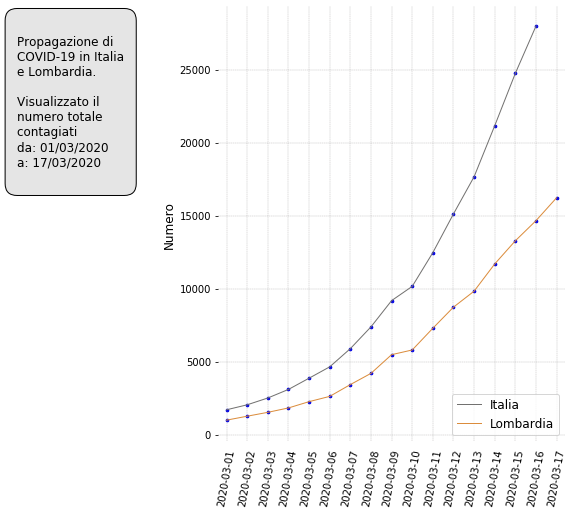

In [29]:
# ------------------------------------------------------
#
# ------------------------------------------------------
date_format = '%d/%m/%Y'
min_date = df_lo["timeStamp"].min().strftime(date_format)
max_date = df_lo["timeStamp"].max().strftime(date_format)
total = f'{df_lo["Totale"].max():n}'

data_sets = {
    "Italy": {
        "df": df,
        "label": "Italia",
        "colors": ["#0000e6", "#727170"]
    },
    "Lombardy": {
        "df": df_lo,
        "label": "Lombardia",
        "colors": ["#0000e6", "#db8c3c"]
    }
}

# ------------------------------------------------------
#
# ------------------------------------------------------
fig = plt.figure(figsize=(10, 8))
gs1 = gridspec.GridSpec(1, 2
                       ,figure=fig
                       ,hspace=0.3
                       ,wspace=0.5 
                       ,width_ratios=[2, 7])

ax = []
ax.append(fig.add_subplot(gs1[0,0]))
ax.append(fig.add_subplot(gs1[0,1]))

idx = 0
text = """
Propagazione di 
COVID-19 in Italia
e Lombardia.

Visualizzato il 
numero totale
contagiati 
da: {mid} 
a: {mad}
""".format(mid=min_date, mad=max_date)

text_box(ax[idx], text, colors=["#e5e5e5", "#000000", "#000000"], x=0.1, y=0.78, fontsize=12)

idx += 1
x = df_lo["timeStamp"].dt.to_pydatetime()
composed_c_virus_chart(ax[idx], data_sets)

plt.savefig(os.path.join(images_path,"covid19_composed_chart.png"))
